## Challenge Spotify

 Challenge par Yassine LARAKI

Spotify développe et met à disposition du public une API permettant de requêter certaines de leurs bases de données. Il existe aujourd’hui plusieurs datasets créés grâce à cette API.
Celui que nous allons utiliser, disponible sur Kaggle, regroupe plus de 115 000 morceaux. Outre des features “classiques” telles qu’artiste, année, genre, le dataset contient également plusieurs features relatives au son lui-même: niveau d’énergie, caractère dansant, … 
L’ensemble de ces features permettent d'analyser le contenu et répondre à de multiples cas d'usages - recommandation de musique, catégorisation du genre, etc.

Le but de ce challenge est de développer un algorithme capable d'estimer la popularité d'une musique provenant de l’un des deux fichiers SpotifyAudioFeaturesNov2018.csv ou SpotifyAudioFeaturesApril2019. Les deux fichiers partagent certains morceaux, qui peuvent avoir des popularités différentes, la popularité d’un morceau étant régulièrement recalculée. Une comparaison entre les deux fichiers n’est pas attendue.


### Importation des librairies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 1/ Pré-traitement des variables

Visualisons la donnée et traitons le fait qu'on ait deux bases de données avec des popularités enregistrées à des instants différents. Une première idée peut être de calculer la moyenne de la popularité d'une musique présente sur les deux datasets, mais on perd complètement l'aspect temporel des mesures. J'ai donc choisi d'ajouter une variable time qui indique quand la popularité a été mesurée. Cette variable vaut 0 si la popularité a été mesurée en novembre 2018 et 1 si elle a été mesurée en avril 2019.

##### Importation et concaténation des données

In [2]:
df0 = pd.read_csv('SpotifyAudioFeaturesNov2018.csv') # Novembre 2018
df1 = pd.read_csv('SpotifyAudioFeaturesApril2019.csv') # Avril 2019

df0["time"] = [0]*len(df0)
df1["time"] = [1]*len(df1)
df = pd.concat([df0, df1])
df.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,time
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44,0
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63,0
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8,0


On crée ainsi une colonne time qui vaut 0 si la mesure de popularité a été effectuée en novembre 2018 et 1 si elle a été effectuée en Avril 2019

##### Nettoyage de la donnée

In [3]:
df.isnull().sum()

artist_name         0
track_id            0
track_name          2
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
popularity          0
time                0
dtype: int64

Comme les NaN sont des noms de musiques, ce ne seront pas des variables descriptives dans notre modèle, on les modifie donc par une valeur par défaut.

In [4]:
df.fillna("No track name", inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247035 entries, 0 to 130662
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       247035 non-null  object 
 1   track_id          247035 non-null  object 
 2   track_name        247035 non-null  object 
 3   acousticness      247035 non-null  float64
 4   danceability      247035 non-null  float64
 5   duration_ms       247035 non-null  int64  
 6   energy            247035 non-null  float64
 7   instrumentalness  247035 non-null  float64
 8   key               247035 non-null  int64  
 9   liveness          247035 non-null  float64
 10  loudness          247035 non-null  float64
 11  mode              247035 non-null  int64  
 12  speechiness       247035 non-null  float64
 13  tempo             247035 non-null  float64
 14  time_signature    247035 non-null  int64  
 15  valence           247035 non-null  float64
 16  popularity        247035 

##### DataFrame avec les valeurs numériques

In [6]:
dfn = df.select_dtypes(include = "number")

##### Description des variables du dataframe

In [7]:
print(f"Le format du DataFrame est : {dfn.shape}" )
dfn.describe()

Le format du DataFrame est : (247035, 15)


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,time
count,247035.000000,247035.000000,2.470350e+05,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000,247035.000000
mean,0.339189,0.581943,2.125922e+05,0.570436,0.226896,5.235663,0.194561,-9.960264,0.607643,0.112104,119.534788,3.880879,0.439048,24.221280,0.528925
std,0.344448,0.189979,1.237054e+05,0.259491,0.361793,3.603272,0.167571,6.525306,0.488277,0.124353,30.155870,0.511664,0.259309,18.894986,0.499164
min,0.000000,0.000000,3.203000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030600,0.460000,1.640000e+05,0.398000,0.000000,2.000000,0.097400,-11.873000,0.000000,0.038900,96.041000,4.000000,0.223000,8.000000,0.000000
50%,0.199000,0.605000,2.018400e+05,0.604000,0.000166,5.000000,0.124000,-7.985000,1.000000,0.055900,120.029000,4.000000,0.420000,22.000000,1.000000
75%,0.629000,0.727000,2.407000e+05,0.776000,0.465000,8.000000,0.235000,-5.692000,1.000000,0.129000,139.716000,4.000000,0.638000,37.000000,1.000000
max,0.996000,0.996000,5.610020e+06,1.000000,1.000000,11.000000,0.999000,1.806000,1.000000,0.966000,249.983000,5.000000,1.000000,100.000000,1.000000


#### Matrice de corrélation

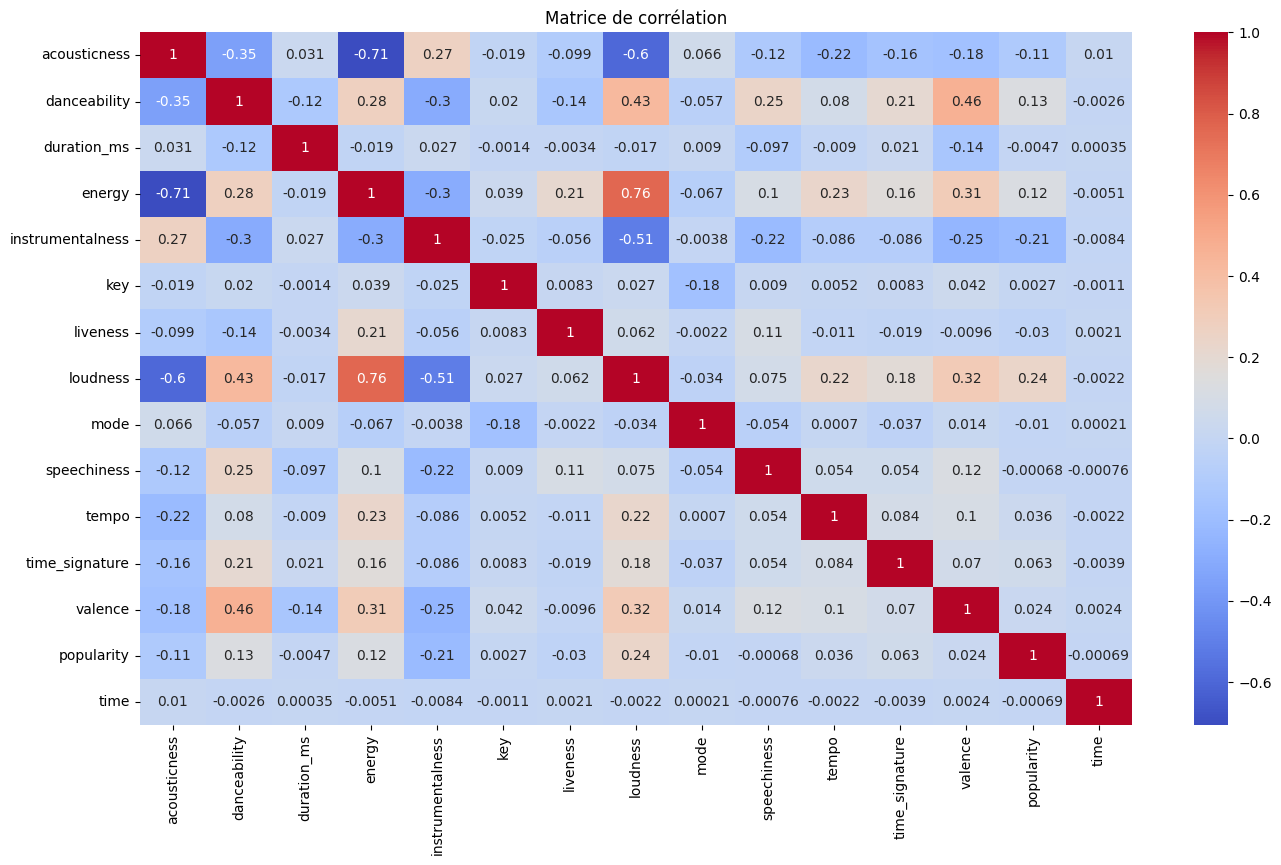

In [8]:
corr = dfn.corr()

plt.figure(figsize = (16,9))
plt.title("Matrice de corrélation")
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Les variables les plus corrélées à la popularité sont loudness et instrumentalness, les deux étant fortement corrélées entre elles.

##### Distribution de la popularité

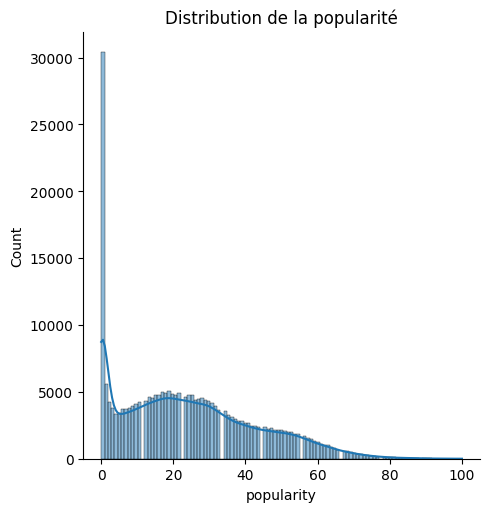

In [9]:
sns.displot(dfn['popularity'], kde = True)
plt.title("Distribution de la popularité")
plt.show()

med_pop = dfn['popularity'].median()

##### Distribution de mode, time_signature et key

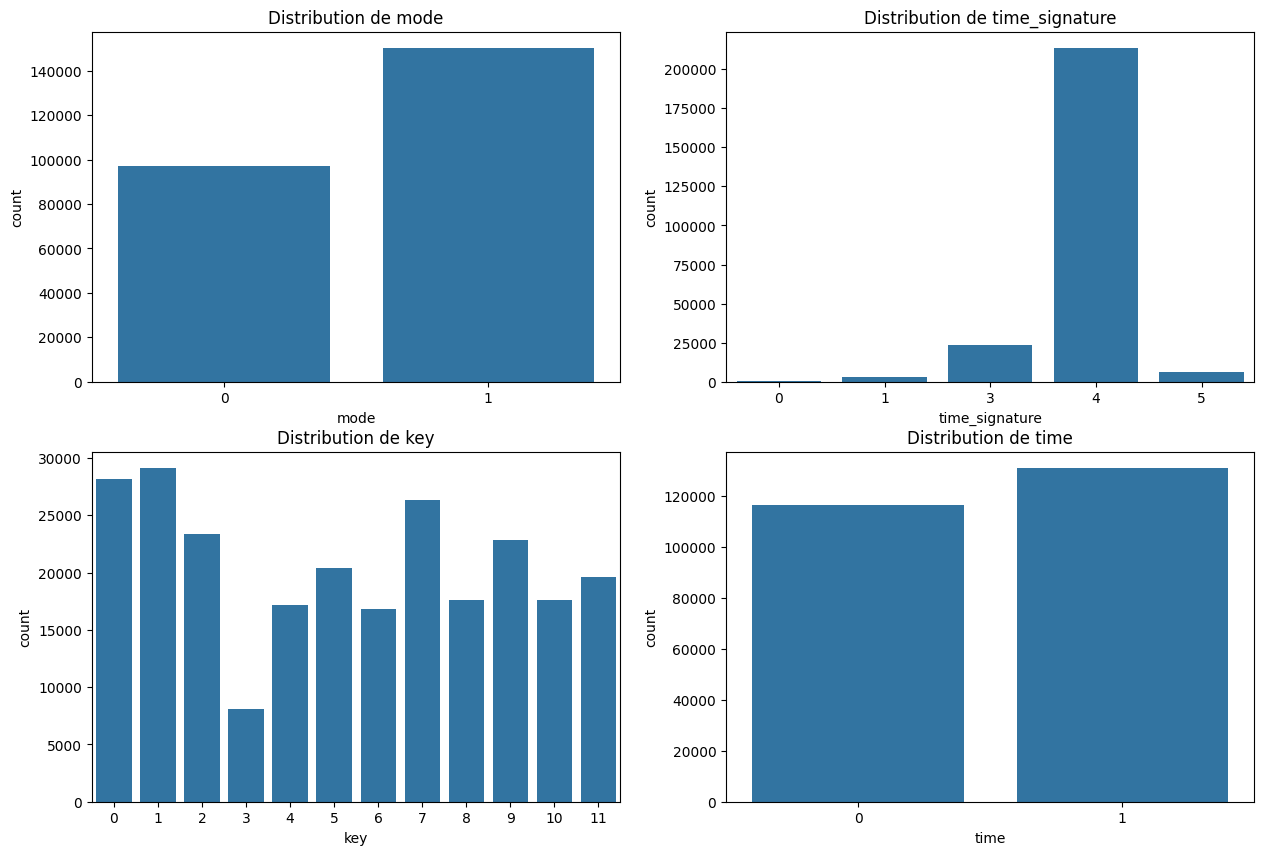

In [10]:
categorical_variables = ["mode", "time_signature", "key", "time"]
plt.figure(figsize=(15,10))
for i in range(len(categorical_variables)):
    xi = categorical_variables[i]
    plt.subplot(2,2,i+1)
    plt.title(f"Distribution de {xi}")
    sns.countplot(data = dfn, x = xi)

plt.show()

##### Popularité moyenne en fonction des catégories

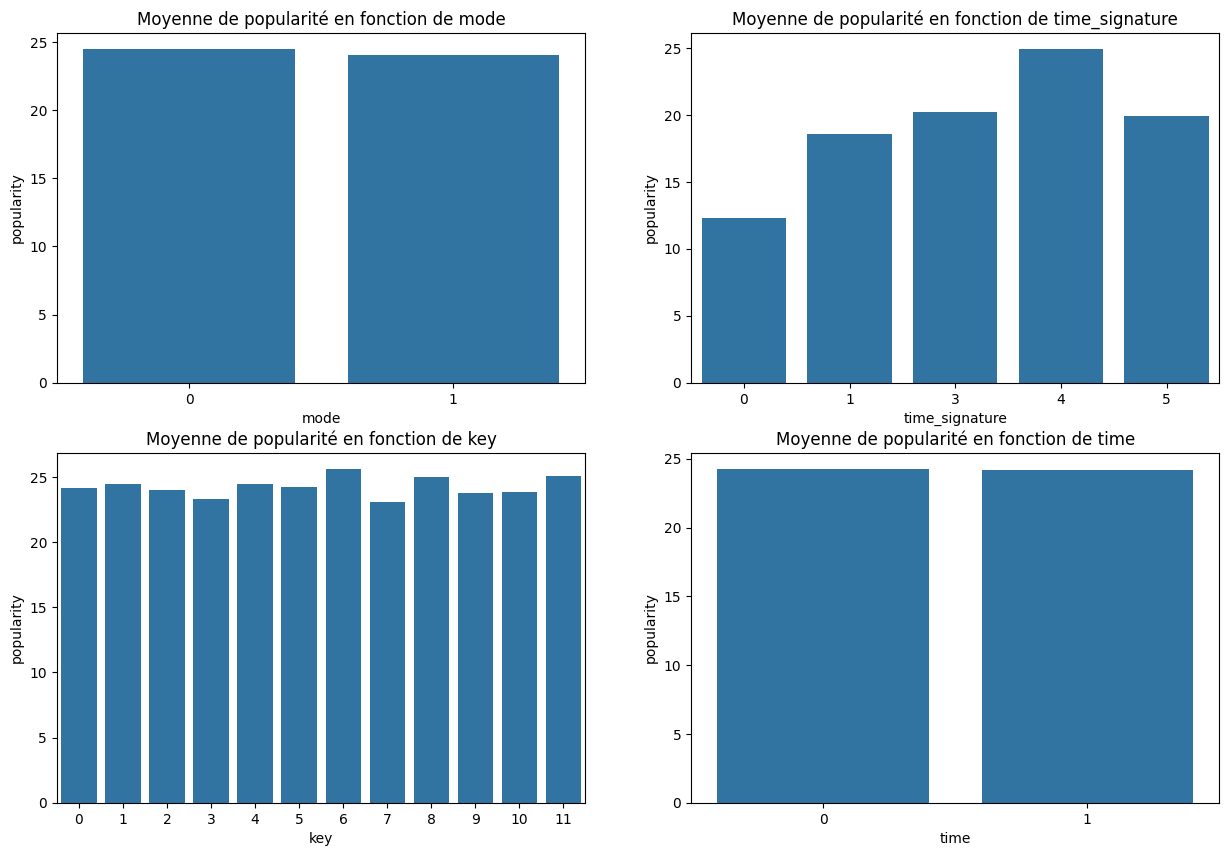

In [11]:
plt.figure(figsize=(15,10))
for i in range(len(categorical_variables)):
    xi = categorical_variables[i]
    plt.subplot(2,2,i+1)
    plt.title(f"Moyenne de popularité en fonction de {xi}")
    dfni = dfn[["popularity", xi]].groupby(xi).mean()
    sns.barplot(data = dfni, x = xi, y = "popularity", errorbar = "sd")
    
plt.show()

Le time_signature 4 est à la fois le plus fréquent et le plus populaire.

##### Comparaison de la distribution des variables non catégorielles en fonction de la popularité

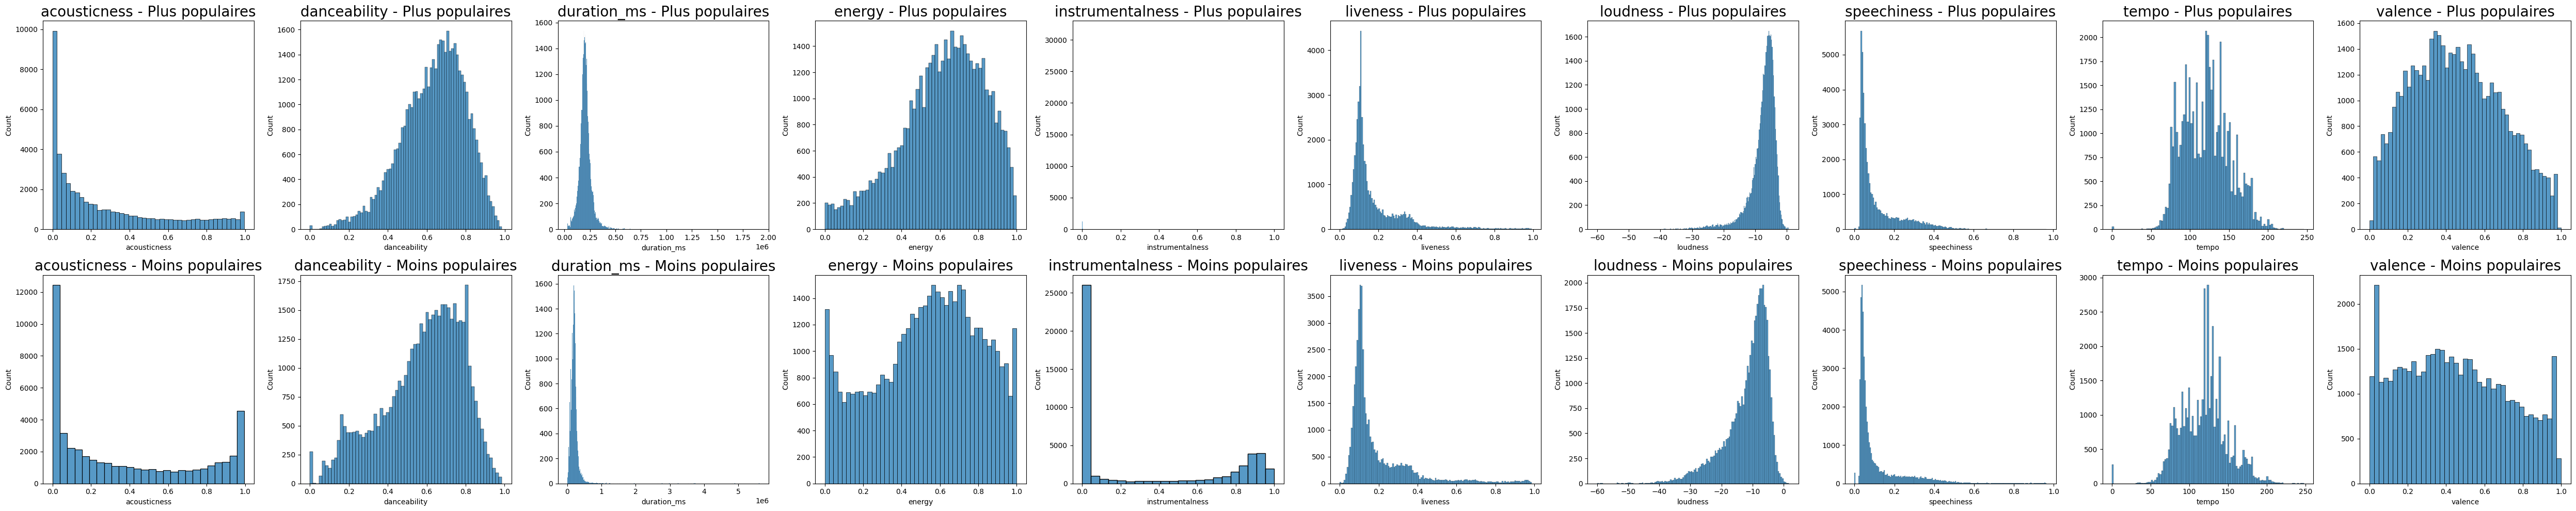

In [12]:
q1 = np.percentile(dfn["popularity"], 20)
q2 = np.percentile(dfn["popularity"], 80)

df_pop = dfn[dfn["popularity"] > q2] # 20% des lignes les plus populaires
df_non_pop = dfn[dfn["popularity"] < q1] # 20% des lignes les moins populaires

features = dfn.columns
non_categorical = [x for x in features if x not in categorical_variables and x != "popularity"]
n = len(non_categorical)

fig, ax = plt.subplots(2, n, figsize=(50, 10))

for i in range(n):
    xi = non_categorical[i]

    sns.histplot(df_pop[xi], ax=ax[0, i])
    ax[0, i].set_title(f'{xi} - Plus populaires', fontsize = 20)

    sns.histplot(df_non_pop[xi], ax=ax[1, i])
    ax[1, i].set_title(f'{xi} - Moins populaires', fontsize = 20)

plt.tight_layout()
plt.show()

    

Il est difficile de dégager des tendances claires. Néanmoins, par exemple, les musiques a très fortes ou basses energy sont peu populaires.

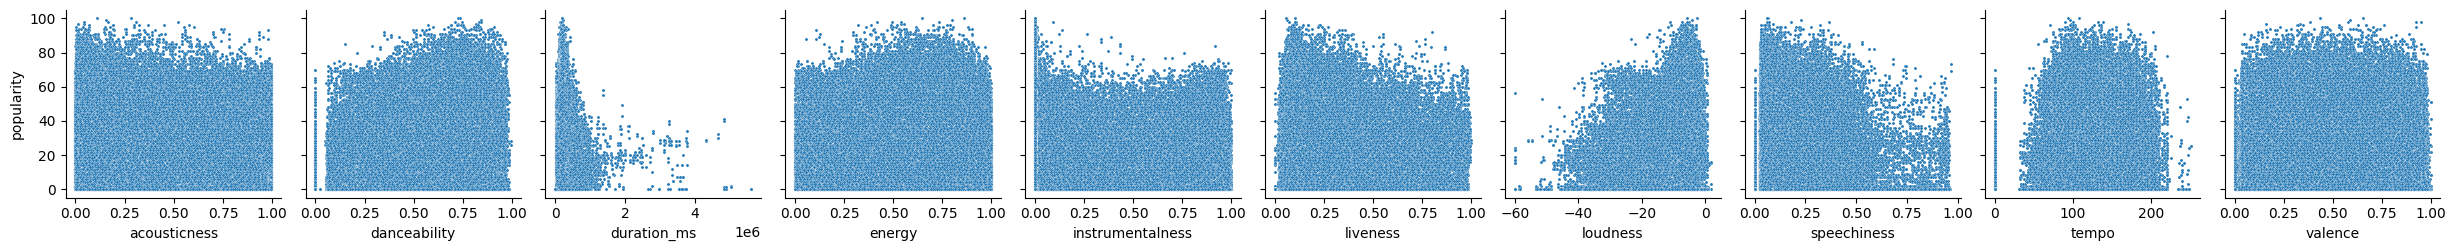

In [13]:
sns.pairplot(dfn[non_categorical+["popularity"]], x_vars = non_categorical, y_vars = ["popularity"], plot_kws = {'s' : 5})

#### Passage des variables en dummies

In [14]:
df = pd.get_dummies(df, drop_first= True,columns=categorical_variables, dtype = "int")
df.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_1
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,0.0812,-7.678,...,0,0,0,0,0,0,0,0,0,0
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,0.2860,-7.259,...,0,0,0,0,0,1,0,0,0,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,0.0824,-5.890,...,0,0,0,0,0,0,1,0,0,0
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,0.0994,-12.118,...,0,0,1,0,0,0,0,0,0,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,0.0332,-10.277,...,0,0,0,0,1,0,0,0,0,0


#### Séparation du train et test, en faisant attention à ce que chaque track ne soit pas présent à la fois dans le test et le train à des dates différentes

In [15]:
from sklearn.model_selection import train_test_split

df_count = df.groupby('track_id').size()
unique_ids = df_count[df_count == 1].index
repeated_ids = df_count[df_count > 1].index

train_ids_repeated, test_ids_repeated = train_test_split(repeated_ids, test_size=0.2)
train_ids_unique, test_ids_unique = train_test_split(unique_ids, test_size=0.2)

train_ids_repeated = pd.Series(train_ids_repeated)
test_ids_repeated = pd.Series(test_ids_repeated)
train_ids_unique = pd.Series(train_ids_unique)
test_ids_unique = pd.Series(test_ids_unique)

train_ids = pd.concat([train_ids_repeated, train_ids_unique])
test_ids = pd.concat([test_ids_repeated, test_ids_unique])

train_df = df[df['track_id'].isin(train_ids)]
test_df = df[df['track_id'].isin(test_ids)]

##### Comme il y a beaucoup trop de musiques peu populaires, faisons un data undersampling

In [16]:
train_df_low = train_df[train_df["popularity"] < 3]
train_df_high = train_df[train_df["popularity"] >= 3]

train_df_low = train_df_low.sample(n=int(len(train_df_low)/7))

train_df = pd.concat([train_df_low, train_df_high])

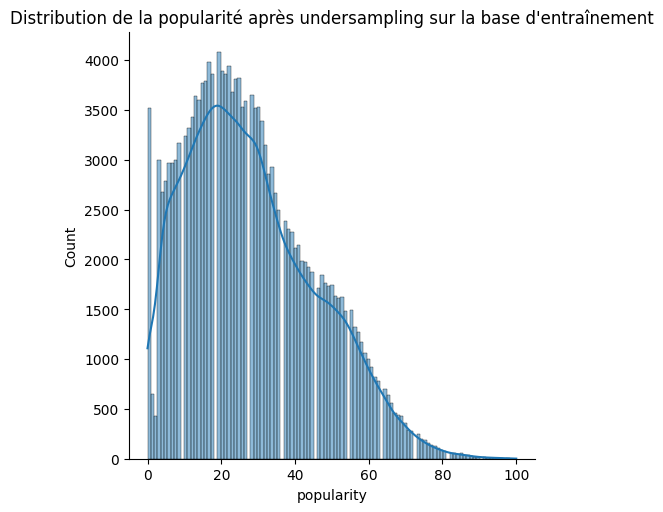

In [17]:
sns.displot(train_df['popularity'], kde = True)
plt.title("Distribution de la popularité après undersampling sur la base d'entraînement")
plt.show()

## 2/ Elaboration du modèle

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

#### Construction de X_train, X_test, y_train et y_test

In [19]:
dfn = df.select_dtypes(include = "number")
x_features = [x for x in dfn.columns if x != "popularity"]
X_train, X_test = train_df[x_features].values, test_df[x_features].values
y_train, y_test = train_df[["popularity"]].values.ravel(), test_df[["popularity"]].values.ravel()
print(f"Format de l'entrée de l'entraînement : {X_train.shape} \nFormat de la sortie de l'entraînement : {y_train.shape}")

Format de l'entrée de l'entraînement : (170007, 27) 
Format de la sortie de l'entraînement : (170007,)


#### Premier modèle naïf, une régression linéaire

In [20]:
model_naive = LinearRegression()
model_naive.fit(X_train, y_train)
pred = model_naive.predict(X_test)
test_rmse = mean_squared_error(y_test, pred, squared=False)
test_r2 = r2_score(y_test, pred)
print("RMSE sur la base de test : ", test_rmse)
print("R2 sur la base de test : ", test_r2)

RMSE sur la base de test :  18.45515747881761
R2 sur la base de test :  0.035003901433550144


#### Random forest

In [21]:
param_grid = {
    'n_estimators': [50, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_grid,
    n_iter=10,  
    cv=5,       
    verbose=2,
    scoring = 'neg_root_mean_squared_error',
    n_jobs= -1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, max_features=log2, min_samples_split=10, n_estimators=50; total time=  16.7s
[CV] END max_depth=None, max_features=log2, min_samples_split=10, n_estimators=50; total time=  17.2s
[CV] END max_depth=None, max_features=log2, min_samples_split=10, n_estimators=50; total time=  17.3s
[CV] END max_depth=None, max_features=log2, min_samples_split=10, n_estimators=50; total time=  17.3s
[CV] END max_depth=None, max_features=log2, min_samples_split=10, n_estimators=50; total time=  17.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  37.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  38.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  38.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  38.3s
[CV] END max_depth=10, max_fe

/Users/yassine/Library/Python/3.11/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=500; total time= 2.9min
[CV] END max_depth=10, max_features=None, min_samples_split=5, n_estimators=50; total time=  47.2s
[CV] END max_depth=20, max_features=None, min_samples_split=2, n_estimators=200; total time= 5.1min
[CV] END max_depth=20, max_features=None, min_samples_split=2, n_estimators=200; total time= 5.3min
[CV] END max_depth=20, max_features=None, min_samples_split=2, n_estimators=200; total time= 5.3min
[CV] END max_depth=20, max_features=None, min_samples_split=2, n_estimators=200; total time= 5.3min
[CV] END max_depth=10, max_features=None, min_samples_split=5, n_estimators=50; total time=  46.4s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=50; total time=   8.1s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=50; total time=   8.4s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=50; total time=   7.7s
[CV

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 200, 500]},
                   scoring='neg_root_mean_squared_error', verbose=2)

### 3/ Évaluation des résultats

In [22]:
print("RMSE des modèles testés :", -random_search.cv_results_["mean_test_score"])
print("Modèle choisi : ", random_search.best_params_)

RMSE des modèles testés : [18.41897845 17.64313411 18.05369582 18.31886058 18.43540671 17.96053019
 18.10565464 17.33837206 18.78070371 18.35950655]
Modèle choisi :  {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': None}


In [23]:
model = random_search.best_estimator_
pred = model.predict(X_test)
test_rmse = mean_squared_error(y_test, pred, squared=False)
print("RMSE sur la base de test : ", test_rmse)

RMSE sur la base de test :  17.743506393439727


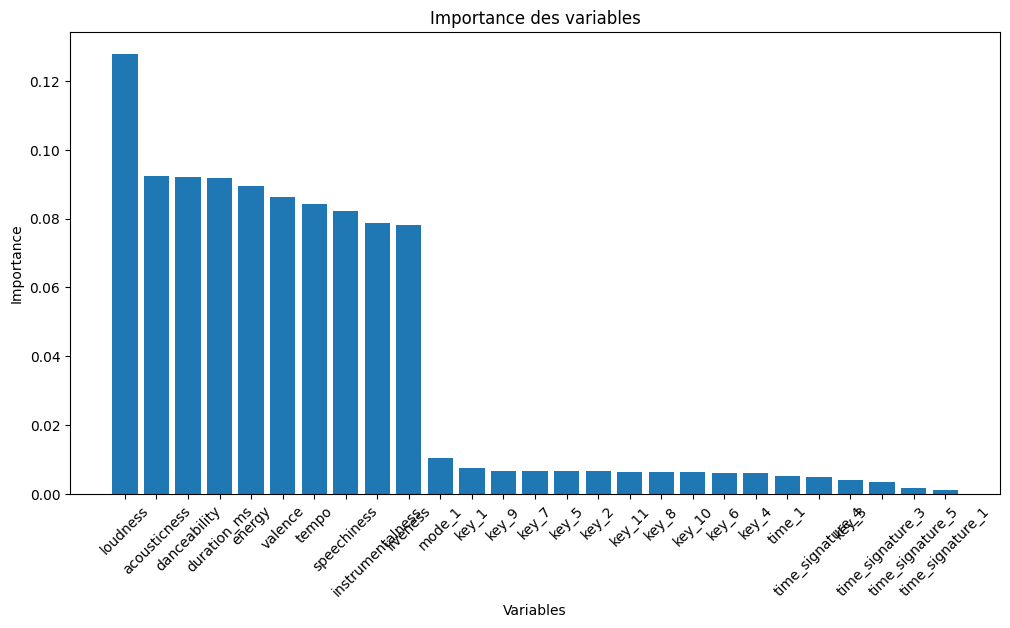

In [24]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

sorted_feature_names = [x_features[i] for i in indices]

plt.figure(figsize=(12, 6))
plt.title("Importance des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation = 45)
plt.xlabel("Variables")
plt.ylabel("Importance") 
plt.show()

#### Calcul des résidus

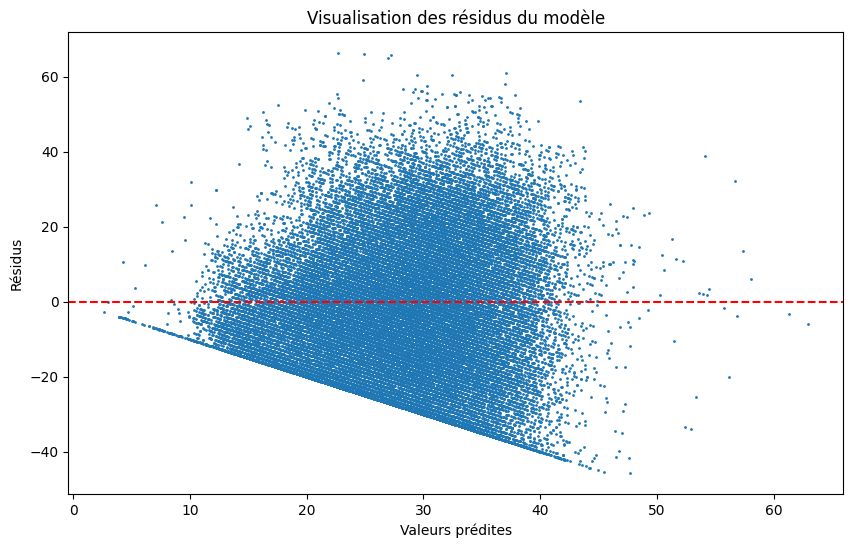

In [25]:
residus = y_test - pred

plt.figure(figsize=(10, 6))
plt.scatter(pred, residus, s = 1)
plt.title('Visualisation des résidus du modèle')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### Pour aller plus loin

Ce travail s'est concentré sur l'élaboration d'un modèle utilisant une unique architecture de machine learning. Au vu de la complexité de la relation des variables entre elles, j'ai opté pour un random forest. Ce type de modèles fonctionne usuellement très bien sur des datasets de cette complexité. Pour être plus exhaustif, nous aurions pu essayer d'autres modèles de ML en les évaluant sur un validation set, avant de choisir le meilleur modèle sur ce validation set, puis de calculer le RMSE sur le test set. Nous pouvons penser évidemment aux Gradient Boosting Regressor, ou même aux réseaux de neurones profonds.

Les résultats obtenus sont peu satisfaisants. Cela s'explique par la difficulté intrinsèque du problème. Prédire la popularité d'un son avec ses caractéristiques intrinsèques est difficile car ces variables sont loins d'expliquer entièrement la popularité de la musique. Néanmoins, les sons à faible popularité étant facilement reconnaissable, on peut imaginer un modèle de classification où la popularité devient une catégorie qui vaut 1 si la popularité est plus grande qu'un seuil (50 par exemple) et 0 sinon. Cela serait davantage prometteur.

Aussi, au vu de la distribution de certaines catégories, on peut penser à réajuster les données en effectuant de la data augmentation par génération synthétique ou en changeant la métrique suivie. On pourrait même à penser à supprimer certaines catégories (on peut penser aux time_signature différents de 4) si l'on considère que l'on ne veut prédire que des musiques de time_signature 4. On peut penser également à réduire la dimensionalité en optant pour des solutions comme le PCA.